In [1]:
import numpy as np
import torch
from torch import distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image
import time
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
import os
%matplotlib inline

%pip install pytorch-ignite
%pip install --pre pytorch-ignite
%pip install torchsummary

from ignite.metrics import FID
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

to_pil_image = T.ToPILImage()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Definition of VAE with Gaussian Prior and Flow-Based Prior (RealNVP)

In [24]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size = 300, latent_size = 100):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 2 * latent_size)
        )
    
    def sample(self, mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + sigma * eps
        
    def forward(self, x):
        h = self.encoder(x)

        mu, log_var = torch.chunk(h, 2, dim=1)
        sigma = torch.exp(0.5*log_var) 
        z = self.sample(mu, sigma)
        
        return z, mu, sigma

class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size = 300, latent_size = 100):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decoder(x)             

class VAE(nn.Module):
    def __init__(self, input_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size)
        self.decoder = Decoder(input_size)
        
    def forward(self, x):
        z, mu, sigma = self.encoder(x)
                
        return self.decoder(z), z, mu, sigma
    
class GaussianPrior(nn.Module):
    def __init__(self, latent_size=100):
        super(GaussianPrior, self).__init__()
        self.latent_size = latent_size

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.latent_size))
        return z

    def log_prob(self, z):
        PI = torch.from_numpy(np.asarray(np.pi)).to(device)
        return -0.5 * torch.log(2. * PI) - 0.5 * z**2.

class FlowPrior(nn.Module):
    def __init__(self, nets, nett, num_flows, D=2):
        super(FlowPrior, self).__init__()

        self.D = D

        self.t = torch.nn.ModuleList([nett() for _ in range(num_flows)])
        self.s = torch.nn.ModuleList([nets() for _ in range(num_flows)])
        self.num_flows = num_flows

    def coupling(self, x, index, forward=True):
        (xa, xb) = torch.chunk(x, 2, 1)

        s = self.s[index](xa)
        t = self.t[index](xa)

        if forward:
            #yb = f^{-1}(x)
            yb = (xb - t) * torch.exp(-s)
        else:
            #xb = f(y)
            yb = torch.exp(s) * xb + t

        return torch.cat((xa, yb), 1), s

    def permute(self, x):
        return x.flip(1)

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in range(self.num_flows):
            z, s = self.coupling(z, i, forward=True)
            z = self.permute(z)
            log_det_J = log_det_J - s.sum(dim=1)

        return z, log_det_J

    def f_inv(self, z):
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x, _ = self.coupling(x, i, forward=False)

        return x

    def sample(self, batch_size):
        z = torch.randn(batch_size, self.D)
        x = self.f_inv(z)
        return x.view(-1, self.D)

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        
        PI = torch.from_numpy(np.asarray(np.pi))
        log_standard_normal = -0.5 * torch.log(2. * PI) - 0.5 * z**2.
        
        log_p = (log_standard_normal + log_det_J.unsqueeze(1))
        return -log_p
    
    
class ELBO():
    def __init__(self, prior):
        self.prior = prior
        self.reconstruction_error = nn.BCELoss(reduction='none')
    
    def kullback_Leibler_divergence(self, z, mu, sigma):
        q = torch.distributions.Normal(mu, sigma)

        log_qz = q.log_prob(z)
        log_pz = self.prior.log_prob(z)
        
        kl = (log_qz - log_pz).sum(-1)
        
        return kl
    
    def __call__(self, inputs, outputs, z, mu, sigma):
        
        re = self.reconstruction_error(outputs, inputs).sum(-1)
        kl = self.kullback_Leibler_divergence(z, mu, sigma)

        elbo = (re + kl)
        return elbo.mean()

In [19]:
def train(net, prior, train_data, val_data, img_dim, batch_size=10, learning_rate=0.0001, epochs=20, nr_test_samples=64, img_dir='None'):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    criterion = ELBO(prior)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

    running_loss = []
    running_val_loss = []
#     m = FID()

    for epoch in range(epochs):
        print("Epoch:" , epoch+1)

        for i, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
            optimizer.zero_grad()

            inputs, _ = data
            inputs = inputs.to(device)

            # Forward
            outputs, z, mu, sigma = net(inputs)
            
            # Backward
            loss = criterion(inputs, outputs, z, mu, sigma)
            loss.backward()
            optimizer.step()
            
            running_loss.append(loss.item())
            
        sample = prior.sample(nr_test_samples)
        generated_img = net.decoder(sample).view(nr_test_samples,img_dim,32,32)
        generated_img = make_grid(generated_img)
        
        im = Image.fromarray(np.array(to_pil_image(generated_img)))
        im.save(f"{img_dir}/epoch_{epoch}.jpeg")
        
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(device)  
                outputs, z, mu, sigma  = net(inputs)
                loss = criterion(inputs, outputs, z, mu, sigma)
                running_val_loss.append(loss)
#                 m.update(outputs, inputs)
                
        print(f'Train Loss: {np.mean(running_loss[-len(train_data):])} | Validation Loss: {np.mean(running_val_loss[-len(val_data):])}')
#         print(m.compute())
    return running_loss, running_val_loss

In [4]:
def plot_interpolated(net, img_dim, n=10):
    w = 32
    img = np.zeros((n*w, n*w, img_dim))
    
    s, e1, e2 = prior.sample(3)
    
    for i, y in enumerate(np.linspace(0, 1, n)):
        for j, x in enumerate(np.linspace(0, 1, n)):
            
            z = s + (e1-s) * x + (e2-s) * y
            generated_image = net.decoder(z.view(-1,100)).view(img_dim, 32,32)

            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w,:] = generated_image.detach().numpy().transpose((1,2,0))
    plt.imshow(img)

## Standard VAE on MNIST

In [5]:
mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=T.Compose([T.Resize(32), T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))]))

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
input_size = 32*32
batch_size=64
net1 = VAE(input_size).to(device)
prior = GaussianPrior()
print("Number of trainable parameters in VAE:", count_parameters(net1))
print("Number of trainable parameters in Prior:", count_parameters(prior))
train_set, val_set = torch.utils.data.random_split(mnist_train, [55000, 5000])
train_loss, val_loss = train(net1, prior, train_set, val_set, 1, batch_size=batch_size, epochs=50, img_dir='VAE/MNIST')

Number of trainable parameters in VAE: 886824
Number of trainable parameters in Prior: 0
Epoch: 1


860it [00:16, 53.02it/s]                                                        


Train Loss: 292.4349386703136 | Validation Loss: 255.05496215820312
Epoch: 2


860it [00:16, 51.96it/s]                                                        


Train Loss: 270.52640639903933 | Validation Loss: 247.61585998535156
Epoch: 3


860it [00:15, 53.77it/s]                                                        


Train Loss: 257.7370800402737 | Validation Loss: 238.0331573486328
Epoch: 4


860it [00:16, 53.01it/s]                                                        


Train Loss: 246.5771317637244 | Validation Loss: 230.4204864501953
Epoch: 5


860it [00:16, 52.24it/s]                                                        


Train Loss: 238.05721427740053 | Validation Loss: 224.21937561035156
Epoch: 6


860it [00:16, 51.93it/s]                                                        


Train Loss: 231.1809135880581 | Validation Loss: 219.0954132080078
Epoch: 7


860it [00:16, 52.96it/s]                                                        


Train Loss: 225.39387952481394 | Validation Loss: 214.5547332763672
Epoch: 8


860it [00:16, 52.11it/s]                                                        


Train Loss: 220.35940015482348 | Validation Loss: 210.52626037597656
Epoch: 9


860it [00:16, 52.60it/s]                                                        


Train Loss: 215.90318707409446 | Validation Loss: 206.82908630371094
Epoch: 10


860it [00:16, 53.48it/s]                                                        


Train Loss: 211.93577920248342 | Validation Loss: 203.5547637939453
Epoch: 11


860it [00:16, 53.34it/s]                                                        


Train Loss: 208.400437774013 | Validation Loss: 200.62680053710938
Epoch: 12


860it [00:16, 53.49it/s]                                                        


Train Loss: 205.24449503255445 | Validation Loss: 197.97860717773438
Epoch: 13


860it [00:16, 53.74it/s]                                                        


Train Loss: 202.41026711233613 | Validation Loss: 195.57725524902344
Epoch: 14


860it [00:16, 52.90it/s]                                                        


Train Loss: 199.84585964291594 | Validation Loss: 193.398681640625
Epoch: 15


860it [00:16, 53.63it/s]                                                        


Train Loss: 197.51730382046958 | Validation Loss: 191.4217987060547
Epoch: 16


860it [00:16, 52.93it/s]                                                        


Train Loss: 195.3907690857732 | Validation Loss: 189.62103271484375
Epoch: 17


860it [00:16, 53.45it/s]                                                        


Train Loss: 193.4428712106436 | Validation Loss: 187.94879150390625
Epoch: 18


860it [00:16, 53.34it/s]                                                        


Train Loss: 191.65147985019732 | Validation Loss: 186.4171905517578
Epoch: 19


860it [00:16, 53.39it/s]                                                        


Train Loss: 189.9996675106128 | Validation Loss: 185.0172119140625
Epoch: 20


860it [00:16, 53.17it/s]                                                        


Train Loss: 188.46904315682346 | Validation Loss: 183.69544982910156
Epoch: 21


860it [00:16, 52.97it/s]                                                        


Train Loss: 187.04804802659078 | Validation Loss: 182.4526824951172
Epoch: 22


860it [00:16, 53.61it/s]                                                        


Train Loss: 185.72144127537283 | Validation Loss: 181.3137969970703
Epoch: 23


860it [00:16, 52.15it/s]                                                        


Train Loss: 184.48396132635997 | Validation Loss: 180.23922729492188
Epoch: 24


860it [00:16, 52.91it/s]                                                        


Train Loss: 183.3236467494521 | Validation Loss: 179.22900390625
Epoch: 25


860it [00:16, 53.18it/s]                                                        


Train Loss: 182.23513560663267 | Validation Loss: 178.28829956054688
Epoch: 26


860it [00:16, 52.37it/s]                                                        


Train Loss: 181.21287631408472 | Validation Loss: 177.40216064453125
Epoch: 27


860it [00:16, 53.50it/s]                                                        


Train Loss: 180.2490695890941 | Validation Loss: 176.56460571289062
Epoch: 28


860it [00:16, 53.35it/s]                                                        


Train Loss: 179.34044581124948 | Validation Loss: 175.7689666748047
Epoch: 29


860it [00:16, 53.21it/s]                                                        


Train Loss: 178.4813484020585 | Validation Loss: 175.02940368652344
Epoch: 30


860it [00:16, 52.29it/s]                                                        


Train Loss: 177.6673381302708 | Validation Loss: 174.3271942138672
Epoch: 31


860it [00:16, 52.63it/s]                                                        


Train Loss: 176.8962001935039 | Validation Loss: 173.6511993408203
Epoch: 32


860it [00:16, 53.26it/s]                                                        


Train Loss: 176.16314192428146 | Validation Loss: 172.9979248046875
Epoch: 33


860it [00:16, 53.50it/s]                                                        


Train Loss: 175.46505635471894 | Validation Loss: 172.39537048339844
Epoch: 34


860it [00:16, 53.62it/s]                                                        


Train Loss: 174.79986268029168 | Validation Loss: 171.81295776367188
Epoch: 35


860it [00:15, 53.78it/s]                                                        


Train Loss: 174.16469766914648 | Validation Loss: 171.25588989257812
Epoch: 36


860it [00:16, 53.66it/s]                                                        


Train Loss: 173.55802390717105 | Validation Loss: 170.71917724609375
Epoch: 37


860it [00:16, 52.33it/s]                                                        


Train Loss: 172.97687585712004 | Validation Loss: 170.2169647216797
Epoch: 38


860it [00:15, 53.78it/s]                                                        


Train Loss: 172.42073970874054 | Validation Loss: 169.72227478027344
Epoch: 39


860it [00:15, 53.98it/s]                                                        


Train Loss: 171.8874534852603 | Validation Loss: 169.25848388671875
Epoch: 40


860it [00:15, 53.89it/s]                                                        


Train Loss: 171.37552774340608 | Validation Loss: 168.81024169921875
Epoch: 41


860it [00:15, 53.92it/s]                                                        


Train Loss: 170.88384498297594 | Validation Loss: 168.38011169433594
Epoch: 42


860it [00:16, 53.08it/s]                                                        


Train Loss: 170.4108295837774 | Validation Loss: 167.96432495117188
Epoch: 43


860it [00:16, 52.69it/s]                                                        


Train Loss: 169.95512433090747 | Validation Loss: 167.5718994140625
Epoch: 44


860it [00:16, 53.73it/s]                                                        


Train Loss: 169.51720163131617 | Validation Loss: 167.1834716796875
Epoch: 45


860it [00:16, 52.44it/s]                                                        


Train Loss: 169.09538814101109 | Validation Loss: 166.8138885498047
Epoch: 46


860it [00:16, 51.91it/s]                                                        


Train Loss: 168.6881218353827 | Validation Loss: 166.4544219970703
Epoch: 47


860it [00:16, 52.89it/s]                                                        


Train Loss: 168.29507399704832 | Validation Loss: 166.1074676513672
Epoch: 48


860it [00:16, 53.66it/s]                                                        


Train Loss: 167.91527670039687 | Validation Loss: 165.7744903564453
Epoch: 49


860it [00:16, 52.42it/s]                                                        


Train Loss: 167.54783106560836 | Validation Loss: 165.44703674316406
Epoch: 50


860it [00:16, 52.86it/s]                                                        


Train Loss: 167.1930569497042 | Validation Loss: 165.13189697265625


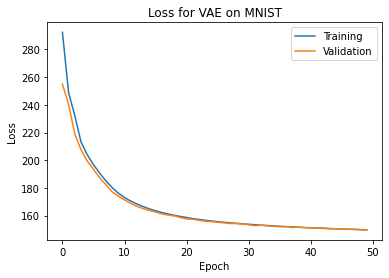

In [8]:
train_loss = np.array(train_loss).reshape(-1, int(55000/64)+1).mean(axis=1)
val_loss = np.array(val_loss).reshape(-1, int(5000/64)+1).mean(axis=1)

plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for VAE on MNIST')
plt.legend()
plt.show()

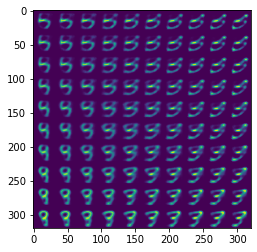

In [9]:
plot_interpolated(net1, 1)

## Standard VAE on SVHN

In [10]:
svhn_train = datasets.SVHN(root='data', download=True, transform=T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))]))

Using downloaded and verified file: data/train_32x32.mat


In [11]:
input_size = 32*32*3
net2 = VAE(input_size).to(device)
prior = GaussianPrior()
print("Number of trainable parameters in VAE:", count_parameters(net2))
print("Number of trainable parameters in Prior:", count_parameters(prior))
train_set, val_set = torch.utils.data.random_split(svhn_train, [65000, 8257])
train_loss, val_loss = train(net2, prior, train_set, val_set, 3, batch_size=batch_size, epochs=50, img_dir='VAE/SVHN')

Number of trainable parameters in VAE: 2117672
Number of trainable parameters in Prior: 0
Epoch: 1


1016it [00:32, 31.04it/s]                                                       


Train Loss: 2017.8541091558502 | Validation Loss: 1988.9156494140625
Epoch: 2


1016it [00:32, 31.61it/s]                                                       


Train Loss: 1999.197005865142 | Validation Loss: 1981.6435546875
Epoch: 3


1016it [00:32, 31.12it/s]                                                       


Train Loss: 1987.1463776836245 | Validation Loss: 1974.1607666015625
Epoch: 4


1016it [00:32, 31.11it/s]                                                       


Train Loss: 1978.8629691056378 | Validation Loss: 1968.1131591796875
Epoch: 5


1016it [00:32, 31.12it/s]                                                       


Train Loss: 1971.9140044445128 | Validation Loss: 1963.1260986328125
Epoch: 6


1016it [00:32, 31.49it/s]                                                       


Train Loss: 1966.6567643133048 | Validation Loss: 1959.056884765625
Epoch: 7


1016it [00:32, 31.04it/s]                                                       


Train Loss: 1962.3683391867123 | Validation Loss: 1955.353271484375
Epoch: 8


1016it [00:32, 31.43it/s]                                                       


Train Loss: 1958.711495091596 | Validation Loss: 1952.4521484375
Epoch: 9


1016it [00:32, 31.54it/s]                                                       


Train Loss: 1955.6323280367847 | Validation Loss: 1950.0777587890625
Epoch: 10


1016it [00:32, 31.53it/s]                                                       


Train Loss: 1952.971247599444 | Validation Loss: 1948.0926513671875
Epoch: 11


1016it [00:32, 30.97it/s]                                                       


Train Loss: 1950.6563567459882 | Validation Loss: 1946.105224609375
Epoch: 12


1016it [00:32, 31.05it/s]                                                       


Train Loss: 1948.563892945217 | Validation Loss: 1944.5211181640625
Epoch: 13


1016it [00:32, 31.27it/s]                                                       


Train Loss: 1946.740325031246 | Validation Loss: 1943.0872802734375
Epoch: 14


1016it [00:33, 30.67it/s]                                                       


Train Loss: 1945.146821020961 | Validation Loss: 1941.898681640625
Epoch: 15


1016it [00:32, 30.87it/s]                                                       


Train Loss: 1943.7365763666749 | Validation Loss: 1940.5235595703125
Epoch: 16


1016it [00:32, 31.37it/s]                                                       


Train Loss: 1942.47411521401 | Validation Loss: 1939.275390625
Epoch: 17


1016it [00:32, 30.93it/s]                                                       


Train Loss: 1941.3303896262173 | Validation Loss: 1938.3443603515625
Epoch: 18


1016it [00:32, 31.01it/s]                                                       


Train Loss: 1940.276245090488 | Validation Loss: 1937.5421142578125
Epoch: 19


1016it [00:32, 31.59it/s]                                                       


Train Loss: 1939.2827566236172 | Validation Loss: 1936.7275390625
Epoch: 20


1016it [00:32, 31.40it/s]                                                       


Train Loss: 1938.3370195944478 | Validation Loss: 1935.993896484375
Epoch: 21


1016it [00:32, 31.56it/s]                                                       


Train Loss: 1937.4480450075575 | Validation Loss: 1935.3363037109375
Epoch: 22


1016it [00:32, 31.71it/s]                                                       


Train Loss: 1936.6069743894386 | Validation Loss: 1934.6455078125
Epoch: 23


1016it [00:32, 31.31it/s]                                                       


Train Loss: 1935.814716024376 | Validation Loss: 1933.9976806640625
Epoch: 24


1016it [00:32, 31.56it/s]                                                       


Train Loss: 1935.077704021624 | Validation Loss: 1933.3604736328125
Epoch: 25


1016it [00:32, 31.55it/s]                                                       


Train Loss: 1934.3911687415416 | Validation Loss: 1932.8172607421875
Epoch: 26


1016it [00:32, 31.40it/s]                                                       


Train Loss: 1933.7503330870732 | Validation Loss: 1932.3206787109375
Epoch: 27


1016it [00:33, 30.53it/s]                                                       


Train Loss: 1933.1497051765218 | Validation Loss: 1931.82763671875
Epoch: 28


1016it [00:32, 30.92it/s]                                                       


Train Loss: 1932.5868595324969 | Validation Loss: 1931.3797607421875
Epoch: 29


1016it [00:32, 31.64it/s]                                                       


Train Loss: 1932.0547355633212 | Validation Loss: 1930.917236328125
Epoch: 30


1016it [00:32, 31.54it/s]                                                       


Train Loss: 1931.551052047449 | Validation Loss: 1930.50830078125
Epoch: 31


1016it [00:32, 31.40it/s]                                                       


Train Loss: 1931.065930960231 | Validation Loss: 1930.0904541015625
Epoch: 32


1016it [00:32, 31.23it/s]                                                       


Train Loss: 1930.6002023539206 | Validation Loss: 1929.736328125
Epoch: 33


1016it [00:33, 30.62it/s]                                                       


Train Loss: 1930.1510277404275 | Validation Loss: 1929.382568359375
Epoch: 34


1016it [00:33, 30.75it/s]                                                       


Train Loss: 1929.7163966339238 | Validation Loss: 1929.034423828125
Epoch: 35


1016it [00:32, 31.24it/s]                                                       


Train Loss: 1929.2998374260987 | Validation Loss: 1928.6417236328125
Epoch: 36


1016it [00:32, 30.79it/s]                                                       


Train Loss: 1928.901668345 | Validation Loss: 1928.32861328125
Epoch: 37


1016it [00:32, 31.27it/s]                                                       


Train Loss: 1928.5199869029648 | Validation Loss: 1927.979248046875
Epoch: 38


1016it [00:32, 31.53it/s]                                                       


Train Loss: 1928.152502759482 | Validation Loss: 1927.6759033203125
Epoch: 39


1016it [00:33, 30.49it/s]                                                       


Train Loss: 1927.799976486739 | Validation Loss: 1927.3948974609375
Epoch: 40


1016it [00:32, 31.52it/s]                                                       


Train Loss: 1927.4612362869143 | Validation Loss: 1927.11962890625
Epoch: 41


1016it [00:32, 31.34it/s]                                                       


Train Loss: 1927.1363721935081 | Validation Loss: 1926.83642578125
Epoch: 42


1016it [00:32, 31.61it/s]                                                       


Train Loss: 1926.82474353334 | Validation Loss: 1926.5635986328125
Epoch: 43


1016it [00:32, 31.30it/s]                                                       


Train Loss: 1926.5253341359066 | Validation Loss: 1926.3131103515625
Epoch: 44


1016it [00:32, 30.99it/s]                                                       


Train Loss: 1926.2367598684498 | Validation Loss: 1926.033203125
Epoch: 45


1016it [00:32, 31.43it/s]                                                       


Train Loss: 1925.9592677666237 | Validation Loss: 1925.7996826171875
Epoch: 46


1016it [00:32, 30.98it/s]                                                       


Train Loss: 1925.6911856714319 | Validation Loss: 1925.5447998046875
Epoch: 47


1016it [00:33, 30.42it/s]                                                       


Train Loss: 1925.4315146204813 | Validation Loss: 1925.3355712890625
Epoch: 48


1016it [00:32, 30.82it/s]                                                       


Train Loss: 1925.1793092217033 | Validation Loss: 1925.089111328125
Epoch: 49


1016it [00:32, 31.41it/s]                                                       


Train Loss: 1924.931926324554 | Validation Loss: 1924.8179931640625
Epoch: 50


1016it [00:32, 31.33it/s]                                                       


Train Loss: 1924.6897040131337 | Validation Loss: 1924.616943359375


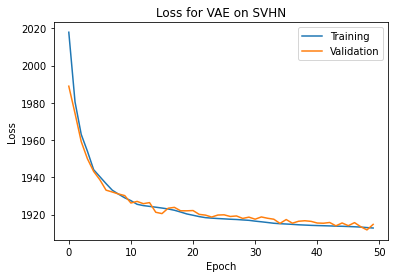

In [13]:
train_loss = np.array(train_loss).reshape(-1, int(65000/64)+1).mean(axis=1)
val_loss = np.array(val_loss).reshape(-1, int(8257/64)+1).mean(axis=1)

plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for VAE on SVHN')
plt.legend()
plt.show()

In [ ]:
plot_interpolated(net2, 3)

## RealNVP on MNIST

In [32]:
num_flows = 3
L = 100
M = 300

nets = lambda: nn.Sequential(nn.Linear(L // 2, M), nn.LeakyReLU(),
                            nn.Linear(M, M), nn.LeakyReLU(),
                            nn.Linear(M, L // 2), nn.Tanh())

nett = lambda: nn.Sequential(nn.Linear(L // 2, M), nn.LeakyReLU(),
                            nn.Linear(M, M), nn.LeakyReLU(),
                            nn.Linear(M, L // 2))

prior = RealNVP(nets, nett, num_flows=num_flows, D=L)

batch_size = 64

TypeError: __init__() missing 1 required positional argument: 'prior'

In [31]:
input_size = 32*32
net3 = VAE(input_size).to(device)
print("Number of trainable parameters in VAE:", count_parameters(net3))
print("Number of trainable parameters in Prior:", count_parameters(prior))
train_set, val_set = torch.utils.data.random_split(mnist_train, [55000, 5000])
train_loss, val_loss = train(net3, prior, train_set, val_set, 1, batch_size=batch_size, epochs=50, img_dir='RealNVP/MNIST')

Epoch: 1


  0%|                                                   | 0/859 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x512 and 50x300)

In [ ]:
train_loss = np.array(train_loss).reshape(-1, int(55000/64)+1).mean(axis=1)
val_loss = np.array(val_loss).reshape(-1, int(5000/64)+1).mean(axis=1)

plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for RealNVP on MNIST')
plt.legend()
plt.show()

In [ ]:
plot_interpolated(net3, 1)

# RealNVP on SVHN

In [ ]:
input_size = 32*32*3

net4 = VAE(input_size).to(device)
print("Number of trainable parameters in VAE:", count_parameters(net4))
print("Number of trainable parameters in Prior:", count_parameters(prior))
train_set_svhn, val_set_svhn = torch.utils.data.random_split(svhn_train, [65000, 8257])
train_loss_svhn, val_loss_svhn = train(net4, prior, train_set_svhn, val_set_svhn, 3, batch_size=batch_size, epochs=50, img_dir='RealNVP/SVHN')

In [ ]:
train_loss_epoch = np.array(train_loss_svhn).reshape(-1, int(60000/64)+1).mean(axis=1)
val_loss_epoch = np.array(val_loss_svhn).reshape(-1, int(13257/64)+1).mean(axis=1)

plt.plot(train_loss_epoch, label='Training')
plt.plot(val_loss_epoch, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for RealNVP on SVHN')
plt.legend()
plt.show()

In [ ]:
plot_interpolated(net4, 3)